# Soft margin classification

In [6]:
#We will load the iris dataset, scale the features, and train a linear SVM
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
x = iris["data"][:, (2, 3)] #petal length, petal width
y = (iris["target"] == 2).astype(np.float64) #Iris virginica

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge")) #The C hyperparameter specifies how hard to make the model
])                                               #A large C makes the model harder (less margin violations), a low C makes the model softer (more margin violations)

svm_clf.fit(x, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge'))])

In [7]:
#Make predictions as usual
svm_clf.predict([[5.5, 1.7]])

array([1.])

# Nonlinear SVM Classification

In [9]:
#One way to deal with nonlinear data is to add features to the data set, such as polynomial features, which were
#covered in the previous chapter. Here we will implement this strategy
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures
x, y = make_moons(n_samples=100, noise=0.15)
polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge"))
])

polynomial_svm_clf.fit(x, y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge'))])

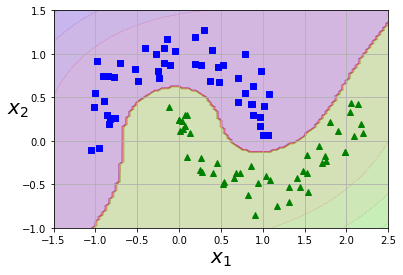

In [14]:
#Here is a graph of the resulting model on the dataset
import matplotlib.pyplot as plt

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    x = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(x).reshape(x0.shape)
    y_decision = clf.decision_function(x).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(x, y, [-1.5, 2.5, -1, 1.5])

plt.show()

In [15]:
#The previous strategy works well, but can be inefficient or inaccurate in certain conditions. The solution is,
#instead of adding polynomial features, to apply the kernel trick which will produce the same result
#as if you had added polynomial features without actually adding them
from sklearn.svm import SVC
poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])
poly_kernel_svm_clf.fit(x, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

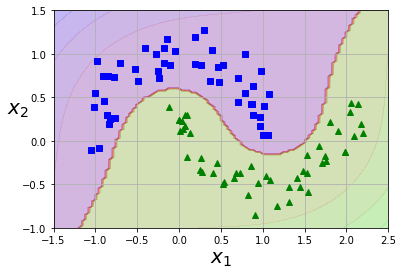

In [24]:
#Here we will plot the kernel trick model
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(x, y, [-1.5, 2.5, -1, 1.5])

plt.show()

In [28]:
#Similarity functioni classification can be implemented by a Gaussian RBF Kernel, which once again implements 
#the kernel trick to save on efficiency
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
])
rbf_kernel_svm_clf.fit(x, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

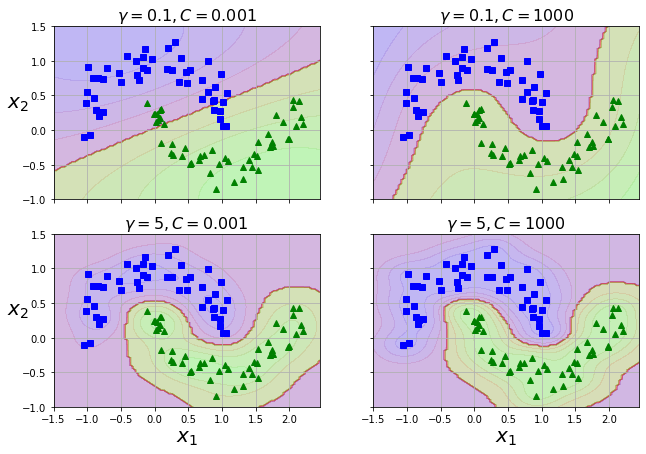

In [29]:
#Here we will show the differences in using varrying gamma and C hyperparameter values
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(x, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(x, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

plt.show()

In [31]:
#As you can see, increasing gamma makes the bellhaped curve narrower, and as a result, each instance's range of influence is smaller, causing
#the decision boundary to be more irregular, wiggling around individual instances. Conversely, a small gamma value makes the bell shaped curve wider,
#so instances have a larger range of influence and the decision boundary ends up smoother. Thus, gamma acts like a regularization parameter:
#if your model is overfitting, reduce it, if it is underfitting, increase it.

In Scikit-Learn, there are many classes for SVM classification. Here is a comparison:


LinearSVC - O(m x n) time complexity, NO out-of-core support, REQUIRES scaling, NO kernel trick<br>
SGDClassifier - O(m x n) time complexity, HAS out-of-core support, REQUIRES scaling, NO kernel trick<br>
SVC - O(m^2 * n) to O(m^3 x n) time complexity, NO out-of-core support, REQUIRES scaling, ALLOWS kernel trick

# SVM Regression

In [36]:
#Let's create a new dataset
np.random.seed(42)
m = 50
x = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [37]:
#You can implement Scikit-Learn's LinearSVR class to perform linear SVM Regression
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5) #epsilon hyperparameter determines the size of the margin, thus allowing more or less margin violations
svm_reg.fit(x, y)

LinearSVR(epsilon=1.5)

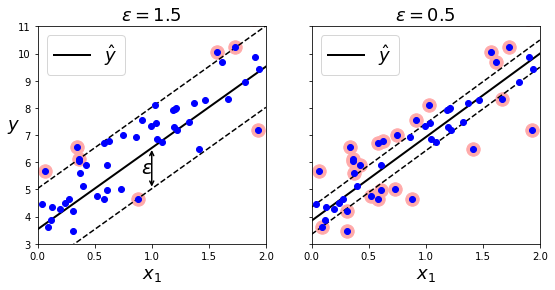

In [39]:
#We can plot what this looks like, and compare how different epsolon values reflect the regression
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, x, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, x, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
plt.show()

In [41]:
#Generate polynomial data
np.random.seed(42)
m = 100
x = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * x + 0.5 * x**2 + np.random.randn(m, 1)/10).ravel()

In [42]:
#For nonlinear regression tasks, you can use a kernelized SVM model
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(x, y)

SVR(C=100, degree=2, kernel='poly')

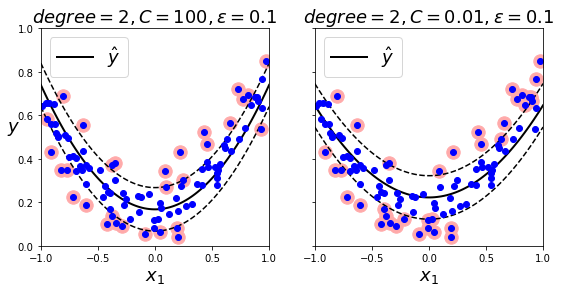

In [43]:
#We can plot what this looks like, and compare how different epsolon values reflect the regression
svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(x, y)
svm_poly_reg2.fit(x, y)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, x, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, x, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
plt.show()

# That is it for SVM's, the book covers a lot of the theory behind these models but it was not codifiable.       